In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Loading the dataset
df = pd.read_csv("../data/raw/blogtext.csv", nrows=5000)
print(df.shape)

(5000, 7)


In [3]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
df.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [5]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5000.0,1.532153e+06,1.302576e+06,467705.0,589736.0,649790.0,3168577.0,4321554.0
age,5000.0,2.954460e+01,7.766008e+00,14.0,24.0,35.0,35.0,46.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5000 non-null   int64 
 1   gender  5000 non-null   object
 2   age     5000 non-null   int64 
 3   topic   5000 non-null   object
 4   sign    5000 non-null   object
 5   date    5000 non-null   object
 6   text    5000 non-null   object
dtypes: int64(2), object(5)
memory usage: 273.6+ KB


In [8]:
# Creating a new dataframe with two columns
df = df[["sign", "text"]]

In [9]:
print(df.shape)

(5000, 2)


In [10]:
pd.set_option("display.max_colwidth", 100)
df.head()

,sign,text
0,Leo,"Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti..."
1,Leo,These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...
2,Leo,In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...
3,Leo,testing!!! testing!!!
4,Aquarius,Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...


In [11]:
# Checking how many unique signs are there
pd.DataFrame(df.sign.unique()).values

array([['Leo'],
       ['Aquarius'],
       ['Aries'],
       ['Capricorn'],
       ['Gemini'],
       ['Cancer'],
       ['Sagittarius'],
       ['Scorpio'],
       ['Libra'],
       ['Virgo'],
       ['Taurus'],
       ['Pisces']], dtype=object)

In [12]:
# Create a new column 'sign_id' with encoded signs 
df["sign_id"] = df["sign"].factorize()[0]
sign_id_df = df[["sign", "sign_id"]].drop_duplicates()

In [13]:
# Dictionaries for future use
sign_to_id = dict(sign_id_df.values)
id_to_sign = dict(sign_id_df[["sign_id", "sign"]].values)

# New dataframe
df.head()

,sign,text,sign_id
0,Leo,"Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti...",0
1,Leo,These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...,0
2,Leo,In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...,0
3,Leo,testing!!! testing!!!,0
4,Aquarius,Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...,1


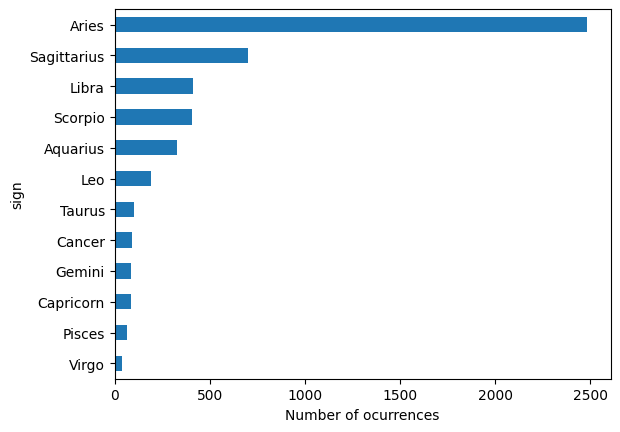

In [14]:
# Visualize the data
fig = plt.figure()
df.groupby("sign").text.count().sort_values().plot.barh(ylim=0)
plt.xlabel("Number of ocurrences", fontsize = 10);

In [15]:
# Pre-processing the "text" column

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# removing punctuation
def remove_punctuation(text):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df.head(2)

,sign,text,sign_id
0,Leo,Info has been found 100 pages and 45 MB of pdf files Now i have to wait untill our t...,0
1,Leo,These are the team members Drewes van der Laag urlLink mail Ruiyu Xie ...,0


In [18]:
# removing unwanted characters
df["text"] = df["text"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', " ", x))

In [19]:
# removing whitespaces (begining and trailing spaces)
df["text"] = df["text"].apply(lambda x: x.strip())

In [20]:
# replacing more than 1 spaces with single space
df["text"] = df["text"].str.replace(r"\s\s+", " ")

In [21]:
# tokenization
def tokenize(text):
    tokens = re.split("\W+", text)
    return tokens

df["text"] = df["text"].apply(lambda x: tokenize(x.lower()))
df.head()

,sign,text,sign_id
0,Leo,"[info, has, been, found, 100, pages, and, 45, mb, of, pdf, files, now, i, have, to, wait, untill...",0
1,Leo,"[these, are, the, team, members, drewes, van, der, laag, urllink, mail, ruiyu, xie, urllink, mai...",0
2,Leo,"[in, het, kader, van, kernfusie, op, aarde, maak, je, eigen, waterstofbom, how, to, build, an, h...",0
3,Leo,"[testing, testing]",0
4,Aquarius,"[thanks, to, yahoos, toolbar, i, can, now, capture, the, urls, of, popupswhich, means, now, i, c...",1


In [22]:
# removing stopwords
stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

df["text"] = df["text"].apply(lambda x: remove_stopwords(x))
df.head()

,sign,text,sign_id
0,Leo,"[info, found, 100, pages, 45, mb, pdf, files, wait, untill, team, leader, processed, learns, html]",0
1,Leo,"[team, members, drewes, van, der, laag, urllink, mail, ruiyu, xie, urllink, mail, bryan, aalderi...",0
2,Leo,"[het, kader, van, kernfusie, op, aarde, maak, je, eigen, waterstofbom, build, hbomb, ascotttarta...",0
3,Leo,"[testing, testing]",0
4,Aquarius,"[thanks, yahoos, toolbar, capture, urls, popupswhich, means, show, cool, links, korean, pop, kpo...",1


In [24]:
wn = nltk.WordNetLemmatizer()

In [25]:
# lemmatization
def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return " ".join(text)

df["text"] = df["text"].apply(lambda x: lemmatization(x))
df.head()

,sign,text,sign_id
0,Leo,info found 100 page 45 mb pdf file wait untill team leader processed learns html,0
1,Leo,team member drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering urllink mail,0
2,Leo,het kader van kernfusie op aarde maak je eigen waterstofbom build hbomb ascotttartarusuwaeduau a...,0
3,Leo,testing testing,0
4,Aquarius,thanks yahoo toolbar capture url popupswhich mean show cool link korean pop kpop audio video wit...,1


In [26]:
# Further Text processing using TF-IDF

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words="english")

In [28]:
# Transforming each text into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.sign_id
features.shape

(5000, 9773)

In [29]:
# Finding the two most correlated terms with each of the sign categories
N = 2
for sign, sign_id in sorted(sign_to_id.items()):
    features_chi2 = chi2(features, labels == sign_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("n--> %s:" %(sign))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n--> Aquarius:
  * Most Correlated Unigrams are: seoul, korean
  * Most Correlated Bigrams are: talked hour, urllink joongang
n--> Aries:
  * Most Correlated Unigrams are: ben, diva
  * Most Correlated Bigrams are: urllink quizilla, brought urllink
n--> Cancer:
  * Most Correlated Unigrams are: employer, resume
  * Most Correlated Bigrams are: cover letter, urllink resume
n--> Capricorn:
  * Most Correlated Unigrams are: golf, bc
  * Most Correlated Bigrams are: college football, fantasy baseball
n--> Gemini:
  * Most Correlated Unigrams are: gona, hav
  * Most Correlated Bigrams are: tampa bay, bought new
n--> Leo:
  * Most Correlated Unigrams are: lyk, reali
  * Most Correlated Bigrams are: sex city, wanted post
n--> Libra:
  * Most Correlated Unigrams are: clue, tomarrow
  * Most Correlated Bigrams are: pick flick, im gonna
n--> Pisces:
  * Most Correlated Unigrams are: brought, quizilla
  * Most Correlated Bigrams are: brought urllink, urllink quizilla
n--> Sagittarius:
  * Most Co

In [30]:
# Multi-classification Modeling

In [31]:
X = df["text"] # Collection of blogs
y = df["sign"] # Target or the labels we want to predict (i.e. the 12 different zodiac signs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [32]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:   
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [33]:
# Compare Text Classification Model performance

In [34]:
mean_accuracy = cv_df.groupby("model_name").accuracy.mean()
std_accuracy = cv_df.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.6590,0.077444
LogisticRegression,0.6226,0.048351
MultinomialNB,0.5230,0.014440
RandomForestClassifier,0.6044,0.057152


In [35]:
# Evaluation of Text Classification Model

In [36]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7216


In [37]:
# Classification report
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3,4,5,6,7,8,9,10,11,12], target_names= df["sign"].unique()))

              precision    recall  f1-score   support

         Leo       0.66      0.40      0.50        99
    Aquarius       0.72      0.95      0.82       610
       Aries       0.86      0.63      0.73        19
   Capricorn       0.33      0.04      0.07        24
      Gemini       0.83      0.40      0.54        25
      Cancer       0.76      0.65      0.70       159
 Sagittarius       0.76      0.47      0.58       111
     Scorpio       0.69      0.68      0.69       106
       Libra       0.00      0.00      0.00         7
       Virgo       0.71      0.36      0.48        28
      Taurus       0.67      0.25      0.36        16
      Pisces       0.00      0.00      0.00         0

   micro avg       0.72      0.74      0.73      1204
   macro avg       0.58      0.40      0.46      1204
weighted avg       0.71      0.74      0.70      1204



c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

In [38]:
# Now let's plot the confusion matrix to check the miss classified predictions:

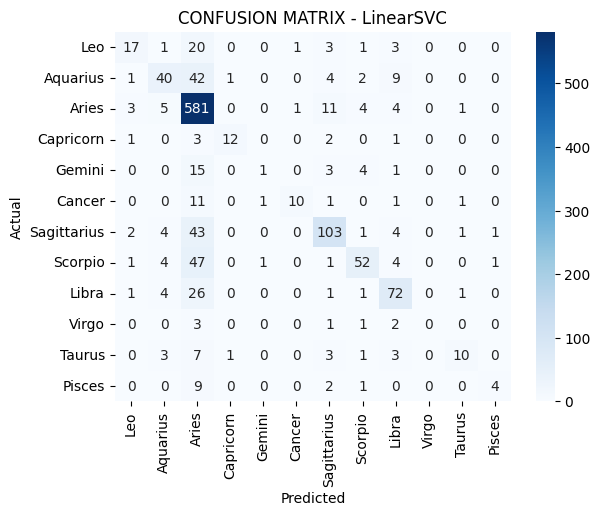

In [39]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=sign_id_df.sign.values, yticklabels=sign_id_df.sign.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX - LinearSVC", size=12);

In [40]:
# Prediction

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words="english")

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [42]:
text = "       Well Kids. Tonight is the big show.  Actually, it's not really big.  There's only four bands, Planet Smashers, Catch 22, Mustard Plug and Big D and the kids table. That's not that many. I miss Warped Tour.  I'm taking the guys up..too bad I don't think I'm taking god up. That would rock rock rock. If god graces me with his presence tonight, I'll be a happy girl. I'll also be a happy girl if I meet some new boys. That's right. Another song you kids need is 'Long Goodnight,' by the get up kids, and 'I belive in a thing called love,' by the darkness. Those are pretty nifty selections. I actually wanted to catch some sleep before we hit the road, but I don't know if I'll be able too. Ugh. This will be interesting. Esecially because I have a high hate-tred, for ska. Yes, I know. That makes no sense, and why am I going right? Well, put it too you this way, it's a show, and It's in Cleveland, only $10 and I'm going with the guys. I've never been to a show with them. This will be fun! .. I think .. If I don't die in the pit first.  I'm going to go, if anyone wants to come along tonight, your more than welcome. Just bring some powerade and all will be fine.    "

print(model.predict(fitted_vectorizer.transform([text])))

['Libra']
